# Лабораторная работа 2.

## Выполнил

Ткачев Алексей Игоревич

Группа 381806-2

ФИИТ

4 курс

# Подключение нужных библиотек

`matplotlib` - для отображения изображений

`numpy` - для удобной и быстрой работы с многомерными массивами

`cv2` - для открытия изображений и более точной работы с ее пикселями.

In [575]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [576]:
def out(img):
  plt.imshow(img)

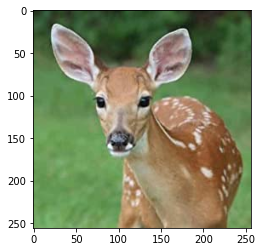

In [577]:
img = cv2.imread("animal.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out(img)

# Сверточные фильтры

Возьмем количество будущих каналов = 5 (`conv_channels_count = 5`), возьмем синаптическое ядро размером `kernel_width` на `kernel_height` (3x3) - такой можно взять, так как изображение небольшое. Возьмем три числа: длину, высоту и ширину изображения. Затем создадим `offset` смещение для каждого канала и создадим `W` - свертку, 4-х мерный массив - натренированные фильтры, детектирующие определенные свойства объектов на изображениях. Зададим также случайный сдвиг `offset` для каждого полученного канала. 

Возьмем нормальное распределение случайных величин, так как оно наиболее распространенное в жизни.

In [578]:
conv_channels_count = 5
kernel_width = 3
kernel_height = kernel_width
image_width = img.shape[0]
image_height = img.shape[1]
image_channels = img.shape[2]
offset = np.random.normal(loc=1, scale=1, size=(conv_channels_count))
W = np.random.normal(loc=1, scale=1, size=(conv_channels_count, kernel_width, kernel_height, image_channels))
offset

array([1.157213  , 1.91309365, 2.22196093, 0.89102901, 2.75019296])

In [579]:
W

array([[[[ 2.59462226e+00,  1.83079451e+00,  6.20748996e-01],
         [-2.07447400e-01, -5.03440892e-02,  1.61082472e-01],
         [ 1.69246921e+00,  3.44003167e-01,  7.33506333e-01]],

        [[ 5.22265562e-01,  1.70456945e+00,  3.13173881e+00],
         [-3.47056177e-01,  1.73194229e+00,  5.29916036e-01],
         [ 1.92007137e+00,  1.24223033e+00,  1.46160732e+00]],

        [[ 1.94452419e+00,  9.95462310e-01, -5.79035597e-01],
         [ 2.24074996e+00,  2.05593597e+00,  2.18406558e+00],
         [ 6.84822866e-01,  2.22888709e+00,  1.22468760e+00]]],


       [[[-3.01014298e-01,  2.51549246e+00,  2.33584772e+00],
         [ 3.63372457e-01,  1.81590398e+00,  1.03415372e+00],
         [ 8.16136027e-01,  2.04626288e+00,  2.09306730e+00]],

        [[ 2.16751191e+00,  6.67999019e-03,  8.31519174e-01],
         [ 8.61832769e-01,  4.13029055e-01,  2.97675614e-01],
         [-3.98113296e-02,  1.85251603e+00,  1.18778867e+00]],

        [[ 4.35634071e-01,  1.04140761e+00,  9.28792468e-0

In [580]:
W.mean()

1.0891193718121552

Далее беря каждое из ядер на границах, те пиксели, которые не вошли в ядро (то есть коориднаты пикселей <0, либо > ширины или длины изобарежния, мы их заполним нулями и своего рода "выкенем из рассчетов". 

Будем считать свертку по формуле:     

$$ ConvRes_{c x y} = \sum_{c=0}^{M-1} \sum_{x=0}^{W-1} \sum_{y=0}^{H-1} offset_{c} + \sum_{r=0}^{R-1} \sum_{s=0}^{S-1} \sum_{k=0}^{K-1} img_{x+r, y+s, k} \cdot W_{c r s}$$

`x, y` - текущие координаты пикселя

`c` - светочный канал

`r, s` - ограничения размеров синаптического ядра

`k` - канал изображения (RGB)

`ConvRes` - наши итоговые 5 сверточных слоев

`offset` - заданное нами случайное смещение

Возьмем функцию `img_clamp`, которая будет не давать выходить за границы картинки. Она вернет `img[x][y][c]`, если оно в пределах интервала размеров изображения, а иначе 0.

Заполним изначально сверточные каналы нулями.

In [581]:
def img_clamp(x, y, x_min, x_max, y_min, y_max, current_image_channel, img):
  if x < x_min or x > x_max or y > y_max or y < y_min:
    return 0
  else:
    return img[x][y][current_image_channel]

conv_result = np.zeros(shape=(conv_channels_count, image_width, image_height), dtype=np.float32)
conv_result

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

In [582]:
conv_result.max(), conv_result.min()

(0.0, 0.0)

In [583]:
from time import time


t = time()

for conv_channel in range(conv_channels_count):

      for x in range(image_width):

          for y in range(image_height):

              conv_result[conv_channel][x][y] = offset[conv_channel]

              for r in range(kernel_width):

                  for s in range(kernel_height):

                      for c in range(image_channels):

                          I = img_clamp(x+r, y+s, 0, image_width-1, 0, image_height-1, c, img)

                          conv_result[conv_channel][x][y] += I * W[m][c][r][s]
time() - t

71.08817601203918

In [584]:
conv_result

array([[[1003.14746,  993.48   ,  991.32666, ...,  944.9854 ,
          558.9473 ,  291.84344],
        [1046.6274 , 1039.4948 , 1045.4302 , ..., 1025.7587 ,
          599.37506,  307.4881 ],
        [1073.5334 , 1064.7605 , 1068.2063 , ..., 1105.0912 ,
          639.3138 ,  328.36966],
        ...,
        [3503.8862 , 3463.8833 , 3433.834  , ..., 3133.142  ,
         1883.9967 , 1000.14874],
        [2353.29   , 2324.9607 , 2306.0066 , ..., 2101.6648 ,
         1302.3273 ,  737.04803],
        [1139.8838 , 1125.8663 , 1113.8832 , ..., 1007.87366,
          802.0789 ,  432.01907]],

       [[1003.9034 ,  994.23584,  992.0825 , ...,  945.7413 ,
          559.7032 ,  292.59933],
        [1047.3834 , 1040.2507 , 1046.186  , ..., 1026.5145 ,
          600.131  ,  308.24396],
        [1074.2893 , 1065.5164 , 1068.9622 , ..., 1105.847  ,
          640.0697 ,  329.12552],
        ...,
        [3504.6423 , 3464.6392 , 3434.5898 , ..., 3133.898  ,
         1884.7526 , 1000.90466],
        [235

Посмотрим общие характеристики полученных чисел всех сверточных каналов:

In [585]:
conv_result.mean(), conv_result.min(), conv_result.max()

(2911.1174, 253.2971, 6814.8516)

# Нормализация

Нормализуем полученные значения по формуле :    

$$ x_{i j} = deform \cdot \frac{(x_{i j} - \mu_j)}{ \sqrt{\sigma^2_{i j} + ɛ}} + offset $$

$$ \mu_j = \frac{1}{N} \sum_{i} x_{i j} $$

$$ \sigma^2_j = \frac{1}{N} \sum_{i} (x_{i j} - \mu_j) ^ 2$$

Учитываем особенности `python`, нам не обязательно прописывать вручную циклы, достаточно работать напрямую со списками. Операция, примененнная к списку, применяется ко всем его элементам.

Возьмем `esp = 1e-9`, чтобы избежать ошибки деления на ноль.


In [586]:
def normalize(x, deform=1, offset=0, eps=1e-9):
  for channel in range(x.shape[0]):
    mean = np.mean(x[channel], axis=0)
    variance_in_square = np.var(x[channel], axis=0)
    x[channel] = deform * (x[channel] - mean) / np.sqrt(variance_in_square + eps)
  return x

np.mean(conv_result[0], axis=0)

array([2730.3003 , 2737.599  , 2741.4685 , 2738.8672 , 2730.2432 ,
       2720.3765 , 2709.6116 , 2700.7302 , 2691.0654 , 2683.533  ,
       2679.1323 , 2681.7485 , 2689.3652 , 2699.7454 , 2715.03   ,
       2720.784  , 2718.3564 , 2699.318  , 2677.9573 , 2720.6865 ,
       2837.9219 , 2983.527  , 3086.0212 , 3135.109  , 3154.2817 ,
       3166.5356 , 3168.792  , 3171.727  , 3174.7324 , 3179.957  ,
       3194.173  , 3204.1465 , 3208.9668 , 3200.0796 , 3186.9375 ,
       3174.0327 , 3162.4822 , 3150.1377 , 3137.3164 , 3123.502  ,
       3113.373  , 3108.2734 , 3104.8782 , 3099.318  , 3093.6414 ,
       3094.152  , 3105.9888 , 3116.654  , 3123.3555 , 3122.685  ,
       3120.0974 , 3119.0508 , 3121.658  , 3120.5115 , 3118.216  ,
       3119.7456 , 3127.9531 , 3131.0186 , 3125.6975 , 3115.7659 ,
       3108.8264 , 3106.9429 , 3103.572  , 3102.4932 , 3110.4832 ,
       3136.448  , 3168.0422 , 3190.502  , 3190.1108 , 3150.8875 ,
       3068.6033 , 3000.6292 , 2971.1443 , 2964.3516 , 2930.85

In [587]:
np.var(conv_result[0], axis=0)

array([ 325189.62 ,  319248.47 ,  312700.2  ,  306549.2  ,  301410.6  ,
        298905.34 ,  292778.22 ,  290287.34 ,  291355.75 ,  295115.03 ,
        301575.1  ,  309268.84 ,  319290.7  ,  327971.9  ,  340239.06 ,
        356953.22 ,  378105.7  ,  405732.28 ,  435417.06 ,  375928.62 ,
        424802.06 ,  726967.7  ,  957519.5  , 1011885.9  ,  981811.94 ,
        901273.94 ,  800470.7  ,  720711.94 ,  672362.5  ,  644023.   ,
        633039.4  ,  627536.75 ,  629651.6  ,  616952.44 ,  595831.6  ,
        580541.94 ,  583127.9  ,  601854.   ,  617737.3  ,  620120.44 ,
        633521.6  ,  656282.94 ,  678086.9  ,  681355.3  ,  666785.2  ,
        656349.4  ,  654912.44 ,  660651.56 ,  663625.25 ,  644835.44 ,
        623510.7  ,  618932.56 ,  626382.25 ,  634726.9  ,  632794.44 ,
        645681.2  ,  677926.4  ,  715663.7  ,  741708.4  ,  765542.3  ,
        792178.94 ,  812232.94 ,  838514.   ,  864741.8  ,  921796.   ,
       1005921.9  , 1144232.9  , 1286741.9  , 1359909.8  , 12952

In [588]:
norm_conv_result = normalize(conv_result)

In [589]:
norm_conv_result.min(), norm_conv_result.max(), norm_conv_result.mean()

(-3.1872706, 3.8008747, 2.9802323e-09)

Видим, что нормализация действительно произошла. Теперь все числа в новых небольших пределах, а среднее значение находится примерно по середине этого интервала.

# ReLU - функция активации

Применим функцию активации, которая пропускает только положительные сигналы "синапсов". Данная функция наиболее быстрая из многих функций активации. 

На вход мы подаем весь массив, в котором автоматически поканально поэлементно примениться `ReLU`.

In [590]:
def ReLU(x):
  return np.maximum(0, x, dtype=np.float32)

In [591]:
relu_norm_conv_result = ReLU(norm_conv_result)
relu_norm_conv_result 

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.3565637 , 1.2854115 , 1.2381444 , ..., 0.9689952 ,
         0.99170685, 1.0561794 ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.3565668 , 1.2854102 , 1.2381436 , ..., 0.9689952 ,
         0.9917037 , 1.0561779 ],
        [0. 

In [592]:
relu_norm_conv_result.mean(), relu_norm_conv_result.min(), relu_norm_conv_result .max(), relu_norm_conv_result .shape

(0.3895727, 0.0, 3.8008747, (5, 256, 256))

Подверждаем, что отрицательных значений больше нет. Следовательно, функция отработала.

# Max Pooling

Итак, мы получили на каждом канале выборку определенных признаков очертаний на изображении. Так как признаки уже выявлены, то настолько большой и подробный канал нам больше не нужен. Уменьшим его, сохранив признаки (уплотним), уменьшив в два раза. Для этого применим операцию `max pooling`, которая "сканирует" ядром (2x2) входной канал и берем из ядра максимальное значение. Следовательно, каждые 4 значения предыдущего канала уплотняются в 1.

Воспользуемся срезами `python`, с помощью их попеременно будет брать квадраты (2x2) по `x` и `y`. То есть сначала ядрами (2х2) пройдемся по первым двум строкам, потом по вторым двум, потом про третьим... и так до конца.

In [593]:
def max_pooling(arr, shape=2):
  conv_channel = arr.shape[0]
  pooled_width = arr.shape[1] // shape
  pooled_height = arr.shape[2] // shape
  res = np.empty((conv_channel, pooled_width, pooled_height), dtype=np.float32)
  for channel in range(conv_channel):
      for x in range(pooled_width):
          for y in range(pooled_height):
              res[channel, x, y] = np.max(arr[channel, x * shape : (x + 1) * shape, y * shape : (y + 1) * shape])
  return res

pooled_relu_norm_conv_result  = max_pooling(relu_norm_conv_result )

In [594]:
relu_norm_conv_result.mean(), relu_norm_conv_result.min(), relu_norm_conv_result.max(), relu_norm_conv_result.shape

(0.3895727, 0.0, 3.8008747, (5, 256, 256))

In [595]:
pooled_relu_norm_conv_result.mean(), pooled_relu_norm_conv_result.min(), pooled_relu_norm_conv_result.max(), pooled_relu_norm_conv_result.shape

(0.45651236, 0.0, 3.8008747, (5, 128, 128))

Видим, что после `max pooling` размеры наших каналов уменьшились в два раза. В этом и был смысл.

# SoftMax - фунция преобразования массива чисел в массив вероятностей

Итак, `softmax` преобразует наши числа в массив вероятностей, то есть их сумма равна единице, и сами они находятся (каждый) на интервале от 0 до 1.

In [596]:
def soft_max(x):
  for channel in range(conv_channels_count):
    x[channel] = np.exp(x[channel]) / sum(np.exp(x[channel]))
  return x

In [597]:
softmax_pooled_relu_norm_conv_result = soft_max(pooled_relu_norm_conv_result)
softmax_pooled_relu_norm_conv_result.shape, softmax_pooled_relu_norm_conv_result.min(), softmax_pooled_relu_norm_conv_result.max()
softmax_pooled_relu_norm_conv_result

array([[[0.00475732, 0.00474802, 0.00475782, ..., 0.00428128,
         0.00437962, 0.00438378],
        [0.00475732, 0.00474802, 0.00475782, ..., 0.00428128,
         0.00437962, 0.00438378],
        [0.00475732, 0.00474802, 0.00475782, ..., 0.00428128,
         0.00437962, 0.00438378],
        ...,
        [0.01488771, 0.01578413, 0.01739918, ..., 0.0095416 ,
         0.00928398, 0.0096978 ],
        [0.01847186, 0.01647824, 0.0191931 , ..., 0.00967777,
         0.01154158, 0.01260498],
        [0.00475732, 0.00474802, 0.00475782, ..., 0.00428128,
         0.00437962, 0.00438378]],

       [[0.00475732, 0.00474802, 0.00475782, ..., 0.00428128,
         0.00437962, 0.00438379],
        [0.00475732, 0.00474802, 0.00475782, ..., 0.00428128,
         0.00437962, 0.00438379],
        [0.00475732, 0.00474802, 0.00475782, ..., 0.00428128,
         0.00437962, 0.00438379],
        ...,
        [0.01488773, 0.01578415, 0.01739916, ..., 0.0095416 ,
         0.00928398, 0.00969781],
        [0.0

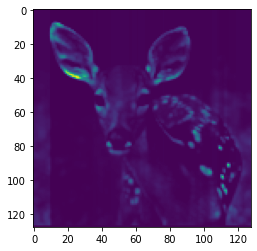

In [598]:
out(softmax_pooled_relu_norm_conv_result[0])

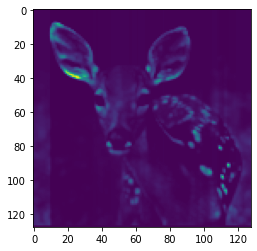

In [599]:
out(softmax_pooled_relu_norm_conv_result[1])

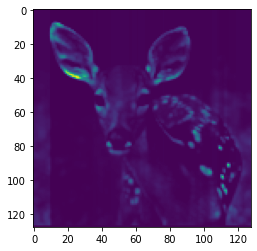

In [600]:
out(softmax_pooled_relu_norm_conv_result[2])

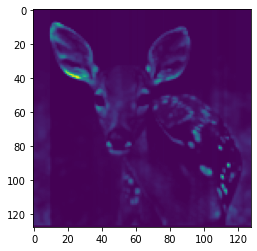

In [601]:
out(softmax_pooled_relu_norm_conv_result[3])

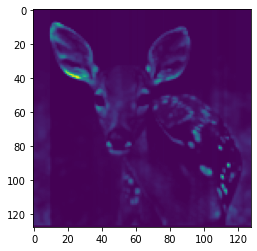

In [602]:
out(softmax_pooled_relu_norm_conv_result[4])